In [1]:
import jax
import jax.numpy as jnp
from chewc.population import quick_haplo
from chewc.sp import SimParam
from chewc.trait import add_trait_a
from chewc.phenotype import set_pheno
from chewc.cross import make_cross
from chewc.predict import gblup_predict
from chewc.population import combine_populations, Population
import matplotlib.pyplot as plt


# Step 1: Create a founder population using quick_haplo
print("Step 1: Creating founder population...")

# Set up parameters as specified
n_ind = 100
n_chr = 5
n_loci_per_chr = 200

# Create JAX random key
key = jax.random.PRNGKey(42)
key, pop_key = jax.random.split(key)

# Create founder population and genetic map
founder_pop, genetic_map = quick_haplo(
    key=pop_key,
    n_ind=n_ind,
    n_chr=n_chr,
    n_loci_per_chr=n_loci_per_chr,
    ploidy=2,
    inbred=False
)

print(f"Created founder population: {founder_pop}")
print(f"Genetic map shape: {genetic_map.shape}")
print(f"Genotype array shape: {founder_pop.geno.shape}")

# Step 2: Initialize SimParam from the founder population
print("\nStep 2: Creating simulation parameters...")

sp = SimParam.from_founder_pop(founder_pop, genetic_map)
print(f"SimParam: {sp}")

# Step 3: Add a quantitative trait
print("\nStep 3: Adding quantitative trait...")

# Set trait parameters as specified
n_qtl_per_chr = 50
trait_mean = jnp.array([100.0])  # Single trait with mean 100
trait_var = jnp.array([10.0])    # Genetic variance of 10

key, trait_key = jax.random.split(key)

# Add the trait to simulation parameters
sp = add_trait_a(
    key=trait_key,
    founder_pop=founder_pop,
    sim_param=sp,
    n_qtl_per_chr=n_qtl_per_chr,
    mean=trait_mean,
    var=trait_var,
    gamma=False  # Use normal distribution
)

print(f"Updated SimParam with traits: {sp}")
print(f"Number of traits: {sp.n_traits}")

# Step 4: Set phenotypes with heritability
print("\nStep 4: Setting phenotypes...")

h2 = 0.3  # Heritability as specified
key, pheno_key = jax.random.split(key)

# Set phenotypes for the population
founder_pop = set_pheno(
    key=pheno_key,
    pop=founder_pop,
    traits=sp.traits,
    ploidy=sp.ploidy,
    h2=jnp.array([h2])
)

print(f"Updated population with phenotypes: {founder_pop}")
print(f"Phenotype shape: {founder_pop.pheno.shape}")

# Step 5: Display summary statistics
print("\nStep 5: Summary statistics...")

# Calculate basic statistics
bv_mean = jnp.mean(founder_pop.bv)
bv_var = jnp.var(founder_pop.bv)
pheno_mean = jnp.mean(founder_pop.pheno)
pheno_var = jnp.var(founder_pop.pheno)

print(f"Breeding value mean: {bv_mean:.2f}")
print(f"Breeding value variance: {bv_var:.2f}")
print(f"Phenotype mean: {pheno_mean:.2f}")
print(f"Phenotype variance: {pheno_var:.2f}")
print(f"Realized heritability: {bv_var/pheno_var:.3f} (target: {h2})")

print("\nChunk 1 complete! Population created with:")
print(f"- {n_ind} individuals")
print(f"- {n_chr} chromosomes")
print(f"- {n_loci_per_chr} loci per chromosome")
print(f"- {n_qtl_per_chr} QTL per chromosome")
print(f"- Trait mean: {float(trait_mean[0])}")
print(f"- Genetic variance: {float(trait_var[0])}")
print(f"- Heritability: {h2}")

# CHUNK 2: Selection and Crossing Protocol
print("\n" + "="*50)
print("CHUNK 2: Selection and Crossing")
print("="*50)

# Step 1: Select top 20% of individuals based on phenotype
print("\nStep 1: Selecting elite founders...")
n_elite = int(0.20 * n_ind)  # 20% of 100 = 20 individuals
print(f"Selecting top {n_elite} individuals from {n_ind} founders")

# Sort by phenotype and get top 20 individuals
phenotype_values = founder_pop.pheno[:, 0]  # First (and only) trait
elite_indices = jnp.argsort(phenotype_values)[-n_elite:]  # Top 20 indices
elite_indices = jnp.sort(elite_indices)  # Sort for consistent ordering

print(f"Elite founder indices: {elite_indices}")
print(f"Elite phenotype range: {phenotype_values[elite_indices].min():.2f} to {phenotype_values[elite_indices].max():.2f}")

# Step 2: Create factorial mating design (10 sires x 10 dams = 100 crosses)
print("\nStep 2: Creating factorial mating design...")
n_sires = 10
n_dams = 10

# Split elite founders into sires and dams
sire_indices = elite_indices[:n_sires]   # First 10 elite individuals as sires
dam_indices = elite_indices[n_sires:]    # Last 10 elite individuals as dams

print(f"Sires: {sire_indices}")
print(f"Dams: {dam_indices}")

# Create cross plan: every sire with every dam
cross_plan = []
for sire_idx in sire_indices:
    for dam_idx in dam_indices:
        cross_plan.append([sire_idx, dam_idx])

cross_plan = jnp.array(cross_plan)
print(f"Cross plan shape: {cross_plan.shape}")
print(f"Number of unique crosses: {cross_plan.shape[0]}")

# Step 3: Generate 5 offspring per cross (total 500 individuals)
print("\nStep 3: Generating offspring...")
n_offspring_per_cross = 5
total_offspring = cross_plan.shape[0] * n_offspring_per_cross

print(f"Generating {n_offspring_per_cross} offspring per cross")
print(f"Total offspring expected: {total_offspring}")

# We need to expand the cross plan to account for multiple offspring per cross
expanded_cross_plan = []
for i in range(cross_plan.shape[0]):
    for j in range(n_offspring_per_cross):
        expanded_cross_plan.append(cross_plan[i])
expanded_cross_plan = jnp.array(expanded_cross_plan)

print(f"Expanded cross plan shape: {expanded_cross_plan.shape}")

# Generate offspring using make_cross
key, cross_key = jax.random.split(key)
next_id_start = founder_pop.nInd  # Start IDs after founder population

training_pop = make_cross(
    key=cross_key,
    pop=founder_pop,
    cross_plan=expanded_cross_plan,
    sp=sp,
    next_id_start=next_id_start
)

print(f"Training population created: {training_pop}")
print(f"Training population size: {training_pop.nInd}")

# Step 4: Set phenotypes for training population
print("\nStep 4: Setting phenotypes for training population...")
key, train_pheno_key = jax.random.split(key)

training_pop = set_pheno(
    key=train_pheno_key,
    pop=training_pop,
    traits=sp.traits,
    ploidy=sp.ploidy,
    h2=jnp.array([h2])
)

# Display training population statistics
print("\nTraining Population Statistics:")
train_bv_mean = jnp.mean(training_pop.bv)
train_bv_var = jnp.var(training_pop.bv)
train_pheno_mean = jnp.mean(training_pop.pheno)
train_pheno_var = jnp.var(training_pop.pheno)

print(f"Training BV mean: {train_bv_mean:.2f}")
print(f"Training BV variance: {train_bv_var:.2f}")
print(f"Training phenotype mean: {train_pheno_mean:.2f}")
print(f"Training phenotype variance: {train_pheno_var:.2f}")
print(f"Training realized heritability: {train_bv_var/train_pheno_var:.3f}")

# Compare founder vs training populations
print("\nFounder vs Training Comparison:")
print(f"Founder phenotype mean: {pheno_mean:.2f} | Training phenotype mean: {train_pheno_mean:.2f}")
print(f"Expected improvement from selection: {jnp.mean(phenotype_values[elite_indices]) - pheno_mean:.2f}")

print("\nChunk 2 complete! Created training population with:")
print(f"- {total_offspring} offspring")
print(f"- From {n_elite} elite founders ({n_sires} sires x {n_dams} dams)")
print(f"- {n_offspring_per_cross} offspring per cross")
print(f"- Factorial mating design")

# CHUNK 3: GBLUP Model Fitting
print("\n" + "="*50)
print("CHUNK 3: GBLUP Model Fitting")
print("="*50)

print("\nFitting GBLUP model to training population...")

# Fit GBLUP model using the training population
# The gblup_predict function will use the phenotypes and genotypes to estimate breeding values
prediction_results = gblup_predict(
    pop=training_pop, 
    h2=h2,  # Use the same heritability as used for phenotype generation
    trait_idx=0  # First (and only) trait
)

print(f"GBLUP model fitted successfully!")
print(f"Prediction results: {type(prediction_results)}")

# Extract GEBVs and other results
gebvs = prediction_results.ebv
reliability = prediction_results.reliability
pev = prediction_results.pev

# Update training population with GEBVs
training_pop = training_pop.replace(ebv=gebvs)

print(f"GEBVs stored in training population")
print(f"GEBV shape: {gebvs.shape}")

# Calculate accuracy statistics
print("\nGBLUP Model Performance:")
true_bv = training_pop.bv[:, 0]
pred_gebv = gebvs[:, 0]

# Calculate correlation between true BV and GEBV (accuracy)
# Remove any NaN values for correlation calculation
valid_mask = ~jnp.isnan(pred_gebv)
if jnp.sum(valid_mask) > 1:
    correlation = jnp.corrcoef(true_bv[valid_mask], pred_gebv[valid_mask])[0, 1]
    mean_reliability = jnp.nanmean(reliability)
    
    print(f"Prediction accuracy (correlation): {correlation:.3f}")
    print(f"Mean reliability: {mean_reliability:.3f}")
    print(f"Individuals with predictions: {jnp.sum(valid_mask)} / {training_pop.nInd}")
else:
    print("Warning: Insufficient valid predictions for accuracy calculation")

# Summary statistics for GEBVs
print(f"\nGEBV Statistics:")
print(f"GEBV mean: {jnp.nanmean(pred_gebv):.2f}")
print(f"GEBV variance: {jnp.nanvar(pred_gebv):.2f}")
print(f"GEBV range: {jnp.nanmin(pred_gebv):.2f} to {jnp.nanmax(pred_gebv):.2f}")

# Compare with true breeding values
print(f"\nTrue BV vs GEBV Comparison:")
print(f"True BV mean: {jnp.mean(true_bv):.2f} | GEBV mean: {jnp.nanmean(pred_gebv):.2f}")
print(f"True BV var: {jnp.var(true_bv):.2f} | GEBV var: {jnp.nanvar(pred_gebv):.2f}")

print("\nChunk 3 complete! GBLUP model fitted with:")
print(f"- Genomic relationship matrix from {training_pop.nInd} individuals")
print(f"- {jnp.sum(~jnp.isnan(training_pop.geno.reshape(training_pop.nInd, -1))).item()} total genotype observations")
print(f"- Heritability: {h2}")
print(f"- GEBVs stored in training_pop.ebv")

# CHUNK 4: Selection and Genomic Prediction Pipeline
print("\n" + "="*50)
print("CHUNK 4: Selection and Genomic Prediction Pipeline")
print("="*50)

# Step 1: Select top 20% (100 individuals) from training population based on phenotype
print("\nStep 1: Selecting top 20% from training population...")
n_selected = int(0.20 * training_pop.nInd)  # 20% of 500 = 100 individuals
print(f"Selecting top {n_selected} individuals from {training_pop.nInd} training individuals")

# Sort by phenotype and get top 100 individuals
train_phenotypes = training_pop.pheno[:, 0]
selected_indices = jnp.argsort(train_phenotypes)[-n_selected:]
selected_indices = jnp.sort(selected_indices)

print(f"Selected individuals: {len(selected_indices)}")
print(f"Phenotype range of selected: {train_phenotypes[selected_indices].min():.2f} to {train_phenotypes[selected_indices].max():.2f}")

# Step 2: Randomly pair them without resampling for 50 pairs
print("\nStep 2: Creating random pairs...")
key, pair_key = jax.random.split(key)

# Shuffle the selected indices and pair them
shuffled_indices = jax.random.permutation(pair_key, selected_indices)
n_pairs = n_selected // 2  # 100 // 2 = 50 pairs

pairs = shuffled_indices.reshape(n_pairs, 2)
print(f"Created {n_pairs} random pairs")
print(f"Pair examples: {pairs[:3]}")  # Show first 3 pairs

# Step 3: Generate 20 offspring per pair (total 1000 individuals)
print("\nStep 3: Generating offspring from pairs...")
n_offspring_per_pair = 20
total_new_offspring = n_pairs * n_offspring_per_pair

print(f"Generating {n_offspring_per_pair} offspring per pair")
print(f"Total new offspring expected: {total_new_offspring}")

# Expand pairs to create cross plan for all offspring
expanded_pairs = []
for pair in pairs:
    for _ in range(n_offspring_per_pair):
        expanded_pairs.append(pair)
expanded_pairs = jnp.array(expanded_pairs)

print(f"Expanded cross plan shape: {expanded_pairs.shape}")

# Generate offspring using make_cross
key, offspring_key = jax.random.split(key)
next_id_start = training_pop.nInd + founder_pop.nInd  # Continue ID numbering

new_generation = make_cross(
    key=offspring_key,
    pop=training_pop,
    cross_plan=expanded_pairs,
    sp=sp,
    next_id_start=next_id_start
)

print(f"New generation created: {new_generation}")
print(f"New generation size: {new_generation.nInd}")

# Step 4: Predict GEBVs using the fitted GBLUP model
print("\nStep 4: Predicting GEBVs for new generation...")

# First, we need to set up the new generation with the training population's genetic architecture
# The GBLUP model was trained on the training population, so we need to apply it to predict the new generation

# For GBLUP prediction, we need to combine genotypes and use the trained model
# Since gblup_predict expects phenotypes, we'll set dummy phenotypes (NaN) for prediction-only individuals
new_generation_with_dummies = new_generation.replace(
    pheno=jnp.full((new_generation.nInd, 1), jnp.nan),  # No phenotypes yet
    bv=jnp.zeros((new_generation.nInd, sp.n_traits)),  # Initialize BV
    ebv=jnp.zeros((new_generation.nInd, 1))  # Initialize EBV with zeros (will be overwritten)
)

# We need to create a combined population for GBLUP that includes both training data and new individuals
# This is a common approach in genomic prediction
print("Creating combined population for GBLUP prediction...")

# Combine genotypes
combined_geno = jnp.concatenate([training_pop.geno, new_generation.geno], axis=0)

# Combine phenotypes (training has real phenotypes, new generation has NaN)
combined_pheno = jnp.concatenate([training_pop.pheno, new_generation_with_dummies.pheno], axis=0)

# Create combined population object for prediction
# We need to properly handle ALL arrays to match the new population size
combined_pop_for_prediction = Population(
    geno=combined_geno,
    pheno=combined_pheno,
    id=jnp.concatenate([training_pop.id, new_generation.id]),
    iid=jnp.arange(combined_geno.shape[0]),  # Reset internal IDs
    mother=jnp.concatenate([training_pop.mother, new_generation.mother]),
    father=jnp.concatenate([training_pop.father, new_generation.father]),
    sex=jnp.concatenate([training_pop.sex, new_generation.sex]),
    fixEff=jnp.concatenate([training_pop.fixEff, new_generation_with_dummies.fixEff]),  # Fix: combine fixEff arrays
    bv=jnp.concatenate([training_pop.bv, new_generation_with_dummies.bv]),
    ebv=jnp.concatenate([training_pop.ebv, new_generation_with_dummies.ebv])  # Now both are non-None
)

print(f"Combined population size: {combined_pop_for_prediction.nInd}")

# Predict GEBVs for the combined population
combined_predictions = gblup_predict(
    pop=combined_pop_for_prediction,
    h2=h2,  # Use same heritability
    trait_idx=0
)

# Extract predictions for the new generation only
new_gen_start_idx = training_pop.nInd
new_gen_gebvs = combined_predictions.ebv[new_gen_start_idx:]
new_gen_reliability = combined_predictions.reliability[new_gen_start_idx:]

# Update new generation with GEBVs
new_generation = new_generation.replace(ebv=new_gen_gebvs)

print(f"GEBVs predicted for new generation")
print(f"New generation GEBV mean: {jnp.nanmean(new_gen_gebvs):.2f}")
print(f"New generation GEBV range: {jnp.nanmin(new_gen_gebvs):.2f} to {jnp.nanmax(new_gen_gebvs):.2f}")

# Step 5: Select top 5% based on GEBVs
print("\nStep 5: Selecting top 5% based on GEBVs...")
n_elite_new = int(0.05 * total_new_offspring)  # 5% of 1000 = 50 individuals
print(f"Selecting top {n_elite_new} individuals from {total_new_offspring} new offspring")

# Select based on GEBVs
new_gen_gebv_values = new_gen_gebvs[:, 0]
elite_new_indices = jnp.argsort(new_gen_gebv_values)[-n_elite_new:]

print(f"Selected {len(elite_new_indices)} elite individuals")
print(f"Elite GEBV range: {new_gen_gebv_values[elite_new_indices].min():.2f} to {new_gen_gebv_values[elite_new_indices].max():.2f}")

# Step 6: Subset into new population object
print("\nStep 6: Creating elite population subset...")
elite_new_pop = Population(
    geno=new_generation.geno[elite_new_indices],
    id=new_generation.id[elite_new_indices],
    iid=jnp.arange(len(elite_new_indices)),  # Reset internal IDs for new population
    mother=new_generation.mother[elite_new_indices],
    father=new_generation.father[elite_new_indices],
    sex=new_generation.sex[elite_new_indices],
    pheno=jnp.zeros((len(elite_new_indices), 1)),  # Will be set in next step
    fixEff=jnp.zeros(len(elite_new_indices), dtype=jnp.float32),
    bv=jnp.zeros((len(elite_new_indices), sp.n_traits)),  # Will be calculated when phenotyped
    ebv=new_generation.ebv[elite_new_indices]
)

print(f"Elite population created: {elite_new_pop}")

# Step 7: Phenotype with heritability of 0.6
print("\nStep 7: Setting phenotypes with h² = 0.6...")
h2_new = 0.6
key, elite_pheno_key = jax.random.split(key)

elite_new_pop = set_pheno(
    key=elite_pheno_key,
    pop=elite_new_pop,
    traits=sp.traits,
    ploidy=sp.ploidy,
    h2=jnp.array([h2_new])
)

print(f"Elite population phenotyped with h² = {h2_new}")
print(f"Elite phenotype mean: {jnp.mean(elite_new_pop.pheno):.2f}")
print(f"Elite phenotype variance: {jnp.var(elite_new_pop.pheno):.2f}")

# Step 8: Combine with training population
print("\nStep 8: Combining elite population with training population...")


# Combine training population with elite new population
final_combined_pop = combine_populations(
    training_pop, 
    elite_new_pop, 
    new_id_start=jnp.max(training_pop.id) + 1
)

print(f"Final combined population: {final_combined_pop}")
print(f"Combined population size: {final_combined_pop.nInd}")
print(f"Training portion: {training_pop.nInd} individuals")
print(f"Elite new portion: {elite_new_pop.nInd} individuals")

print("\nChunk 4 complete! Selection pipeline finished with:")
print(f"- Selected top 20% ({n_selected}) from training population")
print(f"- Created {n_pairs} random pairs")
print(f"- Generated {total_new_offspring} offspring ({n_offspring_per_pair} per pair)")
print(f"- Predicted GEBVs using GBLUP model")
print(f"- Selected top 5% ({n_elite_new}) based on GEBVs")
print(f"- Phenotyped elite with h² = {h2_new}")
print(f"- Combined into final population of {final_combined_pop.nInd} individuals")

Step 1: Creating founder population...
Created founder population: Population(nInd=100, nTraits=0, has_ebv=No)
Genetic map shape: (5, 200)
Genotype array shape: (100, 5, 2, 200)

Step 2: Creating simulation parameters...
SimParam: SimParam(nChr=5, nTraits=0, ploidy=2, sexes='no')

Step 3: Adding quantitative trait...
Updated SimParam with traits: SimParam(nChr=5, nTraits=1, ploidy=2, sexes='no')
Number of traits: 1

Step 4: Setting phenotypes...
Updated population with phenotypes: Population(nInd=100, nTraits=1, has_ebv=No)
Phenotype shape: (100, 1)

Step 5: Summary statistics...
Breeding value mean: 7.18
Breeding value variance: 10.00
Phenotype mean: 100.15
Phenotype variance: 35.15
Realized heritability: 0.285 (target: 0.3)

Chunk 1 complete! Population created with:
- 100 individuals
- 5 chromosomes
- 200 loci per chromosome
- 50 QTL per chromosome
- Trait mean: 100.0
- Genetic variance: 10.0
- Heritability: 0.3

CHUNK 2: Selection and Crossing

Step 1: Selecting elite founders...
S

(array([ 1.,  0.,  5., 11., 27., 27., 18.,  7.,  3.,  1.]),
 array([-3.8155992 , -1.7558167 ,  0.30396581,  2.36374831,  4.42353058,
         6.48331261,  8.54309559, 10.60287857, 12.6626606 , 14.72244263,
        16.78222656]),
 <BarContainer object of 10 artists>)

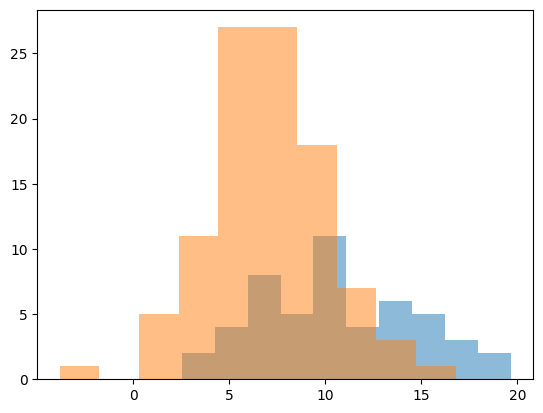

In [2]:
plt.hist(elite_new_pop.bv,alpha=.5)
plt.hist(founder_pop.bv,alpha=.5)